In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from conversion import ECIS_SUMMER_2020, ALL_SITE_FILE, ECE_ORGS

In [3]:
# Column Names
NO_NAME_COL = 'is_missing_name'
HAS_SASID = 'has_sasid'
STUDENT_FACILITY_CODE = 'AssignedFacilityCode'
SITE_FACILITY_CODE = 'Facility Code'
ORG_NAME = 'Parent Org'
SITE_NAME_FACILITY = 'AssignedFacilityName'

In [30]:
# Load student data and drop names & DOB to prevent accidental commit of PII
student_df = pd.read_csv(ECIS_SUMMER_2020, sep='\t')
student_df = student_df[(student_df['FundingEndDate'] > '2019-07-01') | (student_df['FundingEndDate'].isna())]
PII_COLS = ['LastName','SASID','FirstName','MiddleName','Suffix','DateOfBirth','AptStreetNumber', 'StreetAddress1',
       'StreetAddress2','BirthCertificateId','IEPStartDate','EnrollmentId']
student_df[NO_NAME_COL] = student_df['LastName'].isna()
student_df.drop(PII_COLS, axis=1,inplace=True)

In [31]:
student_df[STUDENT_FACILITY_CODE].nunique()

201

In [13]:
# Get site list with facility IDs
facility_df = pd.read_csv(ALL_SITE_FILE, dtype={SITE_FACILITY_CODE:'Int64'})
facility_df.dropna(subset=[SITE_FACILITY_CODE], axis=0, inplace=True)

In [14]:
merged_df = student_df.merge(facility_df, how='left', left_on=STUDENT_FACILITY_CODE, right_on=SITE_FACILITY_CODE)
merged_df[ORG_NAME].fillna(SITE_NAME_FACILITY, inplace=True)
merged_df[SITE_NAME_FACILITY].fillna(SITE_NAME_FACILITY, inplace=True)

In [15]:
merged_df.columns

Index(['If SFY21', 'AssignedFacilityCode', 'AssignedFacilityName', 'Gender',
       'StateOfBirth', 'TownOfBirth', 'ParentsMaidenName',
       'MmrVaccinationDate', 'Ethnicity', 'AmericanIndianOrAlaskaNative',
       'Asian', 'BlackOrAfricanAmerican',
       'NativeHawaiianOrOtherPacificIslander', 'White', 'WhoChildResidesWith',
       'Town', 'State', 'ZipCode', 'NumberOfPeopleInHousehold',
       'AnnualFamilyIncome', 'DateFamilyIncomeDocumented',
       'IncomeNotDisclosed', 'IEP', 'TransportationProvided',
       'FacilityGroupName', 'FacilityEntryDate', 'FacilityExitDate',
       'ExitCategory', 'ExitCategoryCode', 'ExitReason', 'ExitReasonCode',
       'FundingType', 'FundingTypeCode', 'SpaceType', 'SpaceTypeCode',
       'FundingStartDate', 'FundingEndDate', 'HsEhsa', 'HsEhsaCode', 'Oec',
       'Care4Kids', 'NoAdditionalFunding', 'DateCreated', 'LastUpdate',
       'is_missing_name', 'Site Name', 'Region', 'License ID', 'NAEYC ID',
       'Registry ID', 'Facility Code', 'Parent

In [16]:
pd.to_datetime(merged_df.groupby(by=ORG_NAME)['LastUpdate'].max()).dt.strftime('%Y-%m').value_counts().sort_index()

2019-06     1
2019-07     4
2019-08     5
2019-09    79
2020-03     1
2020-06     4
2020-07     2
2020-08     1
2020-09    32
Name: LastUpdate, dtype: int64

In [17]:
org_null_df = merged_df.groupby(by=ORG_NAME)[NO_NAME_COL].sum()
site_null_df = merged_df.groupby(by=SITE_NAME_FACILITY)[NO_NAME_COL].sum()
org_null_df.sort_values(ascending=False).to_csv('data/org_null_name.csv')
site_null_df.sort_values(ascending=False).to_csv('data/site_null_name.csv')

In [18]:
site_df = merged_df.groupby(by=[SITE_NAME_FACILITY, 'Facility Code'])[NO_NAME_COL].sum().reset_index()

In [19]:
site_df = merged_df.groupby(by=[SITE_NAME_FACILITY, 'Facility Code']).agg({NO_NAME_COL: 'sum', 'Facility Code': 'count'})
site_df = site_df.rename(columns={'Facility Code':'total_records'}).reset_index()

In [20]:
ece_df = pd.read_csv(ECE_ORGS, dtype={'facilityCode':str, 'naeycId':str})

In [21]:
site_df['Facility Code'] = site_df['Facility Code'].astype(str)

In [22]:
site_df.merge(ece_df, how='left', left_on = 'Facility Code', right_on='facilityCode').to_csv('data/ecis_sites.csv', index=False)

In [23]:
bins = [-1,0,10,20,30,40,50,100,150,200,500]

In [24]:
pd.cut(org_null_df,bins=bins).value_counts().sort_index()

(-1, 0]        6
(0, 10]       48
(10, 20]      24
(20, 30]      14
(30, 40]      10
(40, 50]       4
(50, 100]     15
(100, 150]     4
(150, 200]     3
(200, 500]     1
Name: is_missing_name, dtype: int64

In [25]:
pd.cut(site_null_df,bins=bins).value_counts().sort_index()

(-1, 0]        9
(0, 10]       73
(10, 20]      37
(20, 30]      22
(30, 40]      12
(40, 50]       7
(50, 100]     14
(100, 150]     3
(150, 200]     2
(200, 500]     0
Name: is_missing_name, dtype: int64

In [26]:
site_null_df[site_null_df.lt(10)].index

Index(['ABCD Inc.-Middlebrooks School Child Care Center',
       'ABCD Inc.-West End Childcare Ctr', 'Andover Elementary School',
       'Benjamin Franklin - Growing Seeds',
       'Bloomfield Early Learning Center Inc.',
       'Bouton Street - Children's Playhouse',
       'Branford Early Learning Center', 'Bridgeport YMCA/SECC PALS 1',
       'Bright and Early Children Learning Center', 'CLC Maple Ave',
       'CLC William Pitt', 'CRT - Children's Learning Center', 'Calvin Hill',
       'Carelot Children's Center - East Lyme',
       'Carelot Children's Center -Killingly',
       'Carelot Children's Center Inc - South Main St.',
       'Carelot Children's Center- Chaplin', 'Center Congregational Preschool',
       'Child Development Center I - The Ark',
       'Children's Learning Center at Mitchell College', 'Children's Village',
       'Community Service Day Care', 'Day Care Center of New Canaan',
       'Dunbar Hill School', 'Early Childhood - CT Office of',
       'Early Childho

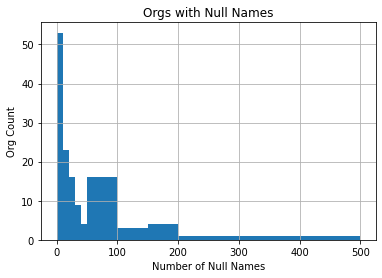

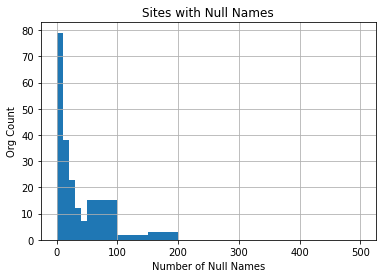

In [27]:
org_null_df.hist(bins=bins)
plt.title('Orgs with Null Names')
plt.xlabel('Number of Null Names')
plt.ylabel('Org Count')
plt.show()
site_null_df.hist(bins=bins)
plt.title('Sites with Null Names')
plt.xlabel('Number of Null Names')
plt.ylabel('Org Count')
plt.show()